In [1]:
import pandas as pd
import data_util
from tqdm import tqdm_notebook as tqdm
from data_generator import DataGenerator
from state_util import StateUtil
from tec_an import TecAn
import numpy as np
from data_util import *
import threading
import multiprocessing

In [2]:
future = 10

def get_tecs(raw_dir = "stock_data/"):
    data_gen = DataGenerator(random=False, base_dir = raw_dir)
    data_gen.rewind()
    stateUtil = StateUtil(data_gen, future = future)
    data = []
    data_count = data_gen.max_steps()
    tec = TecAn()
    for i in tqdm(range(data_count)):
        raw = data_gen.next()
        price = raw[stateUtil.PRICE_KEY]
        amount = raw[stateUtil.AMOUNT_KEY]
        data.append([price, amount])
    
    def calcule_tecs():
        tecs = []
        print("Data {}".format(len(data)))
        df = pd.DataFrame(data, columns = ['Close', 'Volume'])
        close = df['Close']
        volume = df['Volume']
        for ta in tec.tas:
            value = ta(close, volume, 0.0, 0.0)
            tecs.append(value)
        return tecs
    
    return calcule_tecs()


In [3]:

class TacProcess():
    def __init__(self):
        self.old_price = -1
        
    def add_tacs(self, list, index, result):
        list = []
        #print(len(result[-1]))
        #print(index)
        for tec in result:
            list.append(tec.iloc[index])
        return list

    def add_tacs_realtime(self, list, price, amount, tec):
        list = []
        list.extend(tec.add_ta(price, amount))
        self.old_price = price
        #print("{} {} {}".format(price, amount, list))
        return list
    
taProc = TacProcess()

In [4]:
def save(data_set, prefix = "", base_dir = "data/"):
    trainX = data_set[0]
    trainY = data_set[1]
    valX = data_set[2]
    valY = data_set[3]
    final_path = path + base_dir
    train_path = "{}{}trainX.npy".format(final_path, prefix)
    np.save(train_path, trainX)
    np.save("{}{}trainY.npy".format(final_path, prefix), trainY)
    np.save("{}{}valX.npy".format(final_path, prefix), valX)
    np.save("{}{}valY.npy".format(final_path, prefix), valY)
    print("Saving {} with {}".format(train_path, trainX.shape))

def get_y_data(ohlc, shift = -1):
    combined_data = ohlc
    #combined_data['return'] = np.log(combined_data / combined_data.shift(1))
    returns = (ohlc / ohlc.shift(shift))
    combined_data['return'] = returns
    combined_data['direction'] = np.where(combined_data['return'] < 1, 1, 0)
    #print(combined_data)
    #combined_data.dropna(inplace=True)
    #print(combined_data)
    return combined_data['direction']

def split(x, y, split):
    limit = int(len(y)*split)
    
    trainX = np.array(x[limit:].copy())
    trainY = np.array(y[limit:].copy())
    
    valX = np.array(x[:limit].copy())
    valY = np.array(y[:limit].copy())
    print("Completed: {} {} {} {}".format(trainX.shape, trainY.shape, valX.shape, valY.shape))
    return trainX, trainY, valX, valY


TIMESTAMP_KEY = "timestamp"
MICROTIMESTAMP_KEY = "microtimestamp"
ASKS_KEY = "asks"
BIDS_KEY = "bids"
PRICE_KEY = "price"
AMOUNT_KEY = "amount"

In [7]:
path = "./" 

windows = 30

import data_util
from data_generator import DataGenerator

def load_dataset(dir):
    load_datasets([dir])

def load_datasets(dirs, resample, base_dir = "data/"):
    print(dirs)
    sets = []  
    for raw_dir in dirs:
        full_data = base_dir + raw_dir + "/"
        data_gen = DataGenerator(random = False, base_dir = full_data)
        data_gen.rewind()
        data_count = (data_gen.steps - 100)
        tec = TecAn(windows = 20, windows_limit = 100)
        print("Processing {}".format(raw_dir))
        
        list = []
        for i in tqdm(range(data_count)):
            raw = data_gen.next()
            price = raw[PRICE_KEY]
            amount = raw[AMOUNT_KEY]
            timestamp = raw[TIMESTAMP_KEY]
            timestamp = pd.to_datetime(timestamp, unit='s')
            list.append([timestamp, price, amount])

        DATE = 'Date'
        df = pd.DataFrame(list, columns = [DATE, 'Close', 'Volume'])
        df = df.set_index(pd.DatetimeIndex(df[DATE]))

        time = df['Close'].resample(resample)
        ohlc = time.ohlc()
        del ohlc['open']
        del ohlc['high']
        del ohlc['low']
        #(ohlc).plot(figsize=(20, 12))
        
        final_x = []
        for index, row in ohlc.iterrows():
            price = row['close']
            final_x.append(taProc.add_tacs_realtime([], price, 0.0, tec))
            if (np.isnan(final_x).any()):
                print("#########")

        final_y = get_y_data(ohlc, -2)
        
        final_data = split(final_x, final_y, 0.1)

        save(final_data, raw_dir)
        sets.append(final_data)
    return sets

def conc_sets(sets):
    trainX = sets[0][0]
    trainY = sets[0][1]
    valX = sets[0][2]
    valY = sets[0][3]
    for i in range(1,  len(sets)):
        data_set = sets[i]
        trainX = np.append(data_set[0], trainX, axis = 0)
        trainY = np.append(data_set[1], trainY, axis = 0)
        valX = np.append(data_set[2], valX, axis = 0)
        valY = np.append(data_set[3], valY, axis = 0)
    return trainX, trainY, valX, valY



In [14]:
#dirs = ["omgusd", "btceur", "btcusd", "ethusd", "ltcusd", "btcusd17", "btcusdAug19"]
dirs = ["omgusd", "btceur", "btcusd", "ethusd", "ltcusd"]
#dirs = ["btcusd17"]

sets = load_datasets(dirs, '2Min')
save(conc_sets(sets))

['omgusd', 'btceur', 'btcusd', 'ethusd', 'ltcusd']
Processing omgusd


<ipython-input-7-e97f9c3b4bba>:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(data_count)):


  0%|          | 0/213310 [00:00<?, ?it/s]

Completed: (1050, 26) (1050,) (116, 26) (116,)
Saving ./data/omgusdtrainX.npy with (1050, 26)
Processing btceur


<ipython-input-7-e97f9c3b4bba>:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(data_count)):


  0%|          | 0/656764 [00:00<?, ?it/s]

Completed: (1057, 26) (1057,) (117, 26) (117,)
Saving ./data/btceurtrainX.npy with (1057, 26)
Processing btcusd


<ipython-input-7-e97f9c3b4bba>:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(data_count)):


  0%|          | 0/388103 [00:00<?, ?it/s]

Completed: (344, 26) (344,) (38, 26) (38,)
Saving ./data/btcusdtrainX.npy with (344, 26)
Processing ethusd


<ipython-input-7-e97f9c3b4bba>:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(data_count)):


  0%|          | 0/639540 [00:00<?, ?it/s]

Completed: (1057, 26) (1057,) (117, 26) (117,)
Saving ./data/ethusdtrainX.npy with (1057, 26)
Processing ltcusd


<ipython-input-7-e97f9c3b4bba>:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(data_count)):


  0%|          | 0/543146 [00:00<?, ?it/s]

Completed: (1056, 26) (1056,) (117, 26) (117,)
Saving ./data/ltcusdtrainX.npy with (1056, 26)
Saving ./data/trainX.npy with (4564, 26)


In [17]:
np.isnan(sets[0][0]).any()

False

In [1]:
import pandas as pd
import data_util
from tqdm import tqdm_notebook as tqdm
from data_generator import DataGenerator
from state_util import StateUtil
from tec_an import TecAn
import numpy as np


raw_dir = "data/backtest/"
data_gen = DataGenerator(random=False, first_index=0, base_dir = raw_dir)
data_count = data_gen.steps
print(data_gen.next())

{'timestamp': '1624655203', 'microtimestamp': '1624655203055040', 'bids': [['31916.10', '0.00912130'], ['31916.09', '0.23472651'], ['31907.82', '0.02327466'], ['31907.81', '0.39104617'], ['31904.27', '0.06051412'], ['31901.00', '0.00081502'], ['31900.84', '0.00637500'], ['31900.00', '0.96406357'], ['31893.46', '0.06214750'], ['31892.61', '0.39123994'], ['31888.66', '0.06318779'], ['31884.47', '0.73836748'], ['31883.71', '0.56800000'], ['31882.41', '0.22200000'], ['31871.68', '5.54760057'], ['31870.00', '0.00066012'], ['31868.28', '0.62553184'], ['31863.31', '0.72700000'], ['31863.07', '2.65230265']], 'asks': [['31952.39', '0.03936076'], ['31952.40', '4.02390000'], ['31956.80', '0.96000000'], ['31957.07', '0.67346087'], ['31957.08', '0.13341400'], ['31957.18', '0.33745466'], ['31959.30', '10.54900000'], ['31961.39', '0.47535406'], ['31961.41', '0.71649490'], ['31964.49', '0.00150000'], ['31967.80', '0.06266305'], ['31968.49', '0.73535684'], ['31969.81', '0.08608700'], ['31976.48', '0.03

In [2]:
list = []
data_gen.rewind()
TIMESTAMP_KEY = "timestamp"
MICROTIMESTAMP_KEY = "microtimestamp"
ASKS_KEY = "asks"
BIDS_KEY = "bids"
PRICE_KEY = "price"
AMOUNT_KEY = "amount"

for i in tqdm(range(data_count)):
    raw = data_gen.next()
    price = raw[PRICE_KEY]
    amount = raw[AMOUNT_KEY]
    timestamp = raw[TIMESTAMP_KEY]
    timestamp = pd.to_datetime(timestamp, unit='s')
    list.append([timestamp, price, amount])

<ipython-input-2-b5fc16d259d2>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(data_count)):


  0%|          | 0/1286906 [00:00<?, ?it/s]

In [3]:
DATE = 'Date'
df = pd.DataFrame(list, columns = [DATE, 'Close', 'Volume'])
df = df.set_index(pd.DatetimeIndex(df[DATE]))
#print(df.head())
print(df.tail(110))

                                   Date     Close    Volume
Date                                                       
2021-06-27 10:49:17 2021-06-27 10:49:17  32610.00  0.014593
2021-06-27 10:49:17 2021-06-27 10:49:17  32610.00  0.014593
2021-06-27 10:49:17 2021-06-27 10:49:17  32610.00  0.014593
2021-06-27 10:49:17 2021-06-27 10:49:17  32610.00  0.014593
2021-06-27 10:49:17 2021-06-27 10:49:17  32610.00  0.014593
...                                 ...       ...       ...
2021-06-27 10:49:29 2021-06-27 10:49:29  32607.44  0.029350
2021-06-27 10:49:29 2021-06-27 10:49:29  32607.44  0.029350
2021-06-27 10:49:29 2021-06-27 10:49:29  32607.44  0.029350
2021-06-27 10:49:29 2021-06-27 10:49:29  32607.44  0.029350
2021-06-27 10:49:29 2021-06-27 10:49:29  32607.44  0.029350

[110 rows x 3 columns]


(227, 4)
                         open      high       low     close
Date                                                       
2021-06-25 21:03:00  31927.15  31991.55  31601.02  31637.42
2021-06-25 21:13:00  31637.42  31782.55  31563.45  31735.40


<ipython-input-14-fe2aeb23ac1f>:1: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  time = df['Close'].resample('10Min', base = 3)


<AxesSubplot:xlabel='Date'>

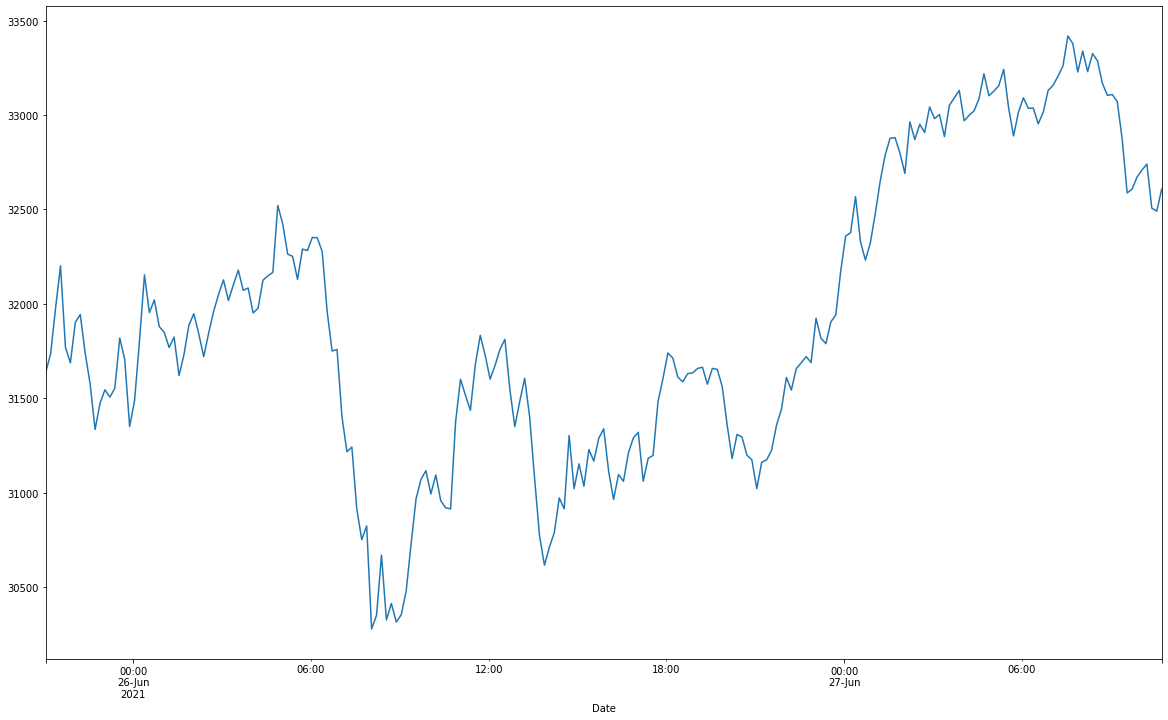

In [14]:
time = df['Close'].resample('10Min', base = 3)
ohlc = time.ohlc()
print(ohlc.shape)
combined_data = ohlc["close"]
print(ohlc.head(2))
(combined_data).plot(figsize=(20, 12))

In [ ]:
combined_data = pd.DataFrame([20, 1, 2, 3, 4, 10, 6, 5, 4, 9, 10], columns = ['Close'])

In [ ]:
combined_data['return'] = np.log(combined_data['Close'] / combined_data['Close'].shift(-1))
combined_data['direction'] = np.where(combined_data['return'] > 0, 0, 1)


In [ ]:
combined_data

In [ ]:
df['result']